# Python for Finance Tutorial For Beginners

*This notebook was made in preparation for the DataCamp tutorial "Python for Finance Tutorial for Beginners"; If you want more explanations on the code or on using Python for Finance, go to the full tutorial [here](https://www.datacamp.com/community/tutorials/finance-python-trading).*

The full tutorial covers the following topics:

* Getting Started With Python For Finance
    - Stocks & Trading
    - Time Series Data
    - Setting Up The Workspace
    - [Python Basics For Finance: Pandas](#basics)
        - Importing Financial Data Into Python
        - Working With Time Series Data 
        - Visualizing Time Series Data
* [Common Financial Analyses](#commonanalyses)
    - Returns
    - Moving Windows
    - Volatility Calculation
    - Ordinary Least-Squares Regression (OLS)
* [Building A Trading Strategy With Python](#tradingstrategy)
* [Backtesting A Strategy](#backtesting)
    - Implementation Of A Simple Backtester
    - Backtesting With Zipline And Quantopian
* Improving A Trading Strategy
* [Evaluating The Trading Strategy](#evaluating)
    - Sharpe Ratio
    - Maximum Drawdown
    - Compound Annual Growth Rate
* What now?

In [12]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

<a id='basics'></a>
## Python Basics For Finance: Pandas

### Importing Data
At this moment, there is a lot going on in the open-source community because of the changes to the Yahoo! Finance API. That's why you don't only use the `pandas_datareader` package, but also a custom fix `fix_yahoo_finance` to get your data:

In [13]:
!pip install yfinance --upgrade --no-cache-dir

In [14]:
!pip install fix-yahoo-finance

In [33]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2012, 1, 1))
aapl.head()

ModuleNotFoundError: No module named 'pandas_datareader'

The `pandas_datareader` offers a lot of possibilities to get financial data. If you don't want to make use of this package, however, you can also use Quandl to retrieve data:

In [16]:
!pip install Quandl

In [17]:
import quandl 
aapl = quandl.get("WIKI/AAPL", start_date="2006-10-01", end_date="2012-01-01")
aapl.head()

QuandlError: (Status 403) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.

In [ ]:
# Alternatively, you can load in a data set that has been retrieved for you already from Yahoo! Finance: 
aapl = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/aapl.csv", header=0, index_col= 0, names=['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], parse_dates=True)

### Working With Time Series Data

In [ ]:
# Inspect the index 
print(aapl.index)

# Inspect the columns
print(aapl.columns)

# Select only the last 10 observations of `Close`
ts = aapl['Close'][-10:]

# Check the type of `ts` 
type(ts)

In [ ]:
# Inspect the first rows of November-December 2006
print(aapl.loc[pd.Timestamp('2006-11-01'):pd.Timestamp('2006-12-31')].head())

# Inspect the first rows of 2007 
print(aapl.loc['2007'].head())

# Inspect November 2006
print(aapl.iloc[22:43])

# Inspect the 'Open' and 'Close' values at 2006-11-01 and 2006-12-01
print(aapl.iloc[[22,43], [0, 3]])

In [ ]:
# Sample 20 rows
sample = aapl.sample(20)

# Print `sample`
print(sample)

# Resample to monthly level 
monthly_aapl = aapl.resample('M')

# Print `monthly_aapl`
print(monthly_aapl)

In [ ]:
# Add a column `diff` to `aapl` 
aapl['diff'] = aapl.Open - aapl.Close

# Delete the new `diff` column
del aapl['diff']

In [ ]:
# Import Matplotlib's `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Plot the closing prices for `aapl`
aapl['Close'].plot(grid=True)

# Show the plot
plt.show()

<a id='commonanalyses'></a>
## Common Financial Analysis

### Returns

In [ ]:
# Assign `Adj Close` to `daily_close`
daily_close = aapl[['Adj Close']]

# Daily returns
daily_pct_c = daily_close.pct_change()

# Replace NA values with 0
daily_pct_c.fillna(0, inplace=True)

# Inspect daily returns
print(daily_pct_c)

# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)

# Print daily log returns
print(daily_log_returns)

In [ ]:
# Resample `aapl` to business months, take last observation as value 
monthly = aapl.resample('BM').apply(lambda x: x[-1])

# Calculate the monthly percentage change
monthly.pct_change()

# Resample `aapl` to quarters, take the mean as value per quarter
quarter = aapl.resample("4M").mean()

# Calculate the quarterly percentage change
quarter.pct_change()

In [ ]:
# Daily returns
daily_pct_c = daily_close / daily_close.shift(1) - 1

# Print `daily_pct_c`
print(daily_pct_c)

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot the distribution of `daily_pct_c`
daily_pct_c.hist(bins=50)

# Show the plot
plt.show()

# Pull up summary statistics
print(daily_pct_c.describe())

In [ ]:
# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_c).cumprod()

# Print `cum_daily_return`
print(cum_daily_return)

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(12,8))

# Show the plot
plt.show()

In [18]:
# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Print the `cum_monthly_return`
print(cum_monthly_return)

NameError: name 'cum_daily_return' is not defined

In [19]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1))
all_data.head()

ModuleNotFoundError: No module named 'pandas_datareader'

In [20]:
#all_data = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/all_stock_data.csv", index_col= [0,1], header=0, parse_dates=[1])

In [21]:
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

NameError: name 'all_data' is not defined

In [22]:
# Plot a scatter matrix with the `daily_pct_change` data 
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))

# Show the plot
plt.show()

NameError: name 'daily_pct_change' is not defined

### Moving Windows

In [23]:
# Isolate the adjusted closing prices 
adj_close_px = aapl['Adj Close']

# Calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()

# Inspect the result
moving_avg[-10:]

NameError: name 'aapl' is not defined

In [24]:
# Short moving window rolling mean
aapl['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
aapl['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', '42', '252']].plot()

plt.show()

NameError: name 'adj_close_px' is not defined

### Volatility Calculation

In [25]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

NameError: name 'daily_pct_change' is not defined

### Ordinary Least-Squares Regression (OLS)

<a id='tradingstrategy'></a>
## Building A Trading Strategy With Python

In [26]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

NameError: name 'aapl' is not defined

NameError: name 'aapl' is not defined

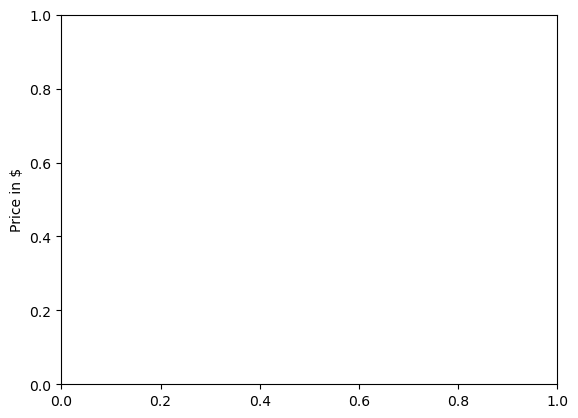

In [27]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

<a id='backtesting'></a>
## Backtesting A Strategy

### Implementation Of A Simple Backtester With Pandas

In [28]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

NameError: name 'signals' is not defined

NameError: name 'portfolio' is not defined

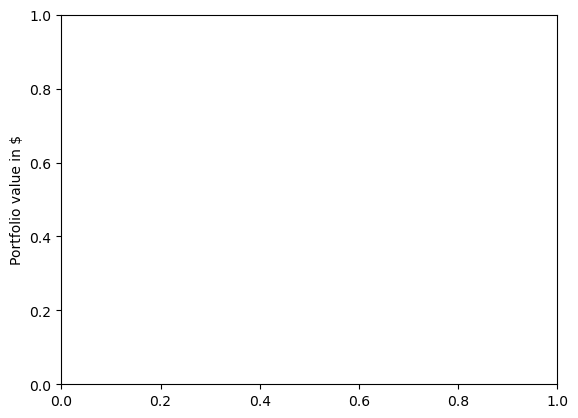

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

<a id='evaluating'></a>
## Evaluating Moving Average Crossover Strategy 

### Sharpe Ratio

In [30]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

NameError: name 'portfolio' is not defined

### Maximum Drawdown

In [31]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = aapl['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

NameError: name 'aapl' is not defined

### Compound Annual Growth Rate (CAGR)

In [32]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1

# Print CAGR
print(cagr)

NameError: name 'aapl' is not defined